<h2><center>Tracking Data Visualizations</center></h2>
<h2><center>Kevin Dewandeler</center></h2>

### Importing packages and necessary data

In [1]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time

## Tracking data and some lines from https://github.com/sealneaward/nba-movement-data

## Github note: you'll need to unzip the .7z file to get to the .json file found below

file = '0021500492.json'
file_data = open(file)
game_id = file.replace('.json', '')
data = json.load(file_data)

In [2]:
## Draw court function (found on internet) - will make visualizations look much better

from matplotlib.patches import Circle, Rectangle, Arc

# Function to draw the basketball court lines
def draw_court(ax=None, color="gray", lw=1, zorder=0):
    
    if ax is None:
        ax = plt.gca()

    # Creates the out of bounds lines around the court
    outer = Rectangle((0,-50), width=94, height=50, color=color,
                      zorder=zorder, fill=False, lw=lw)

    # The left and right basketball hoops
    l_hoop = Circle((5.35,-25), radius=.75, lw=lw, fill=False, 
                    color=color, zorder=zorder)
    r_hoop = Circle((88.65,-25), radius=.75, lw=lw, fill=False,
                    color=color, zorder=zorder)
    
    # Left and right backboards
    l_backboard = Rectangle((4,-28), 0, 6, lw=lw, color=color,
                            zorder=zorder)
    r_backboard = Rectangle((90, -28), 0, 6, lw=lw,color=color,
                            zorder=zorder)

    # Left and right paint areas
    l_outer_box = Rectangle((0, -33), 19, 16, lw=lw, fill=False,
                            color=color, zorder=zorder)    
    l_inner_box = Rectangle((0, -31), 19, 12, lw=lw, fill=False,
                            color=color, zorder=zorder)
    r_outer_box = Rectangle((75, -33), 19, 16, lw=lw, fill=False,
                            color=color, zorder=zorder)

    r_inner_box = Rectangle((75, -31), 19, 12, lw=lw, fill=False,
                            color=color, zorder=zorder)

    # Left and right free throw circles
    l_free_throw = Circle((19,-25), radius=6, lw=lw, fill=False,
                          color=color, zorder=zorder)
    r_free_throw = Circle((75, -25), radius=6, lw=lw, fill=False,
                          color=color, zorder=zorder)

    # Left and right corner 3-PT lines
    # a represents the top lines
    # b represents the bottom lines
    l_corner_a = Rectangle((0,-3), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    l_corner_b = Rectangle((0,-47), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    r_corner_a = Rectangle((80, -3), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    r_corner_b = Rectangle((80, -47), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    
    # Left and right 3-PT line arcs
    l_arc = Arc((5,-25), 47.5, 47.5, theta1=292, theta2=68, lw=lw,
                color=color, zorder=zorder)
    r_arc = Arc((89, -25), 47.5, 47.5, theta1=112, theta2=248, lw=lw,
                color=color, zorder=zorder)

    # half_court
    # ax.axvline(470)
    half_court = Rectangle((47,-50), 0, 50, lw=lw, color=color,
                           zorder=zorder)

    hc_big_circle = Circle((47, -25), radius=6, lw=lw, fill=False,
                           color=color, zorder=zorder)
    hc_sm_circle = Circle((47, -25), radius=2, lw=lw, fill=False,
                          color=color, zorder=zorder)

    court_elements = [l_hoop, l_backboard, l_outer_box, outer,
                      l_inner_box, l_free_throw, l_corner_a,
                      l_corner_b, l_arc, r_hoop, r_backboard, 
                      r_outer_box, r_inner_box, r_free_throw,
                      r_corner_a, r_corner_b, r_arc, half_court,
                      hc_big_circle, hc_sm_circle]

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [3]:
## Initializing dataframe 'movement' which contains the entire game's tracking data
## Some of these lines are from the Github link in the last cell^

movement_headers = ["team_id", "player_id", "x_loc", "y_loc", "radius", "game_clock", "shot_clock", 
                    "quarter", "game_id",
                    "event_id"]
events = data['events']
moments = []

for event in events:
    event_id = event['eventId']
    movement_data = event['moments']
    for moment in movement_data:
        for player in moment[5]:
            player.extend((moment[2], moment[3], moment[0], game_id, event_id))
            moments.append(player)

movement = pd.DataFrame(moments, columns=movement_headers)

In [4]:
## Looking at a subset (3 possessions)

test = movement[movement['event_id']=='2'].reset_index(drop = True)

Looking at the structure of this data - there's one line for every person (or ball) being tracked.

This isn't ideal for graphing - I'm going to have to pivot this data so that one row contains all players and the ball.

In [5]:
test.head()

,team_id,player_id,x_loc,y_loc,radius,game_clock,shot_clock,quarter,game_id,event_id
0,-1,-1,33.08382,41.39121,5.78885,713.26,13.15,1,0021500492,2
1,1610612761,2449,33.40603,24.21082,0.00000,713.26,13.15,1,0021500492,2
2,1610612761,201960,18.95987,5.98142,0.00000,713.26,13.15,1,0021500492,2
3,1610612761,200768,10.77643,38.39262,0.00000,713.26,13.15,1,0021500492,2
4,1610612761,201942,32.76517,42.28548,0.00000,713.26,13.15,1,0021500492,2


There are 10ish lines between the ball (when team_id == -1) - these are the players.

How to only select these players?

### Creating new dataframe called 'newtest' - a shorter, flattened version of 'test'

In [6]:
##Finding the ball, keeping only these records

ball_index = list(test[test['team_id']==-1].index)
teams = test[test['team_id'] != -1]['team_id'].unique()

ball_x_coordinates = []
ball_y_coordinates = []

for i in test[test['team_id']==-1].index:
    ball_x_coordinates.append(test.iloc[i]['x_loc'].tolist())
    ball_y_coordinates.append(test.iloc[i]['y_loc'].tolist())
    
new_test = pd.DataFrame()
new_test['Ball_X'] = ball_x_coordinates
new_test['Ball_Y'] = ball_y_coordinates

In [7]:
new_test.head()

,Ball_X,Ball_Y
0,33.08382,41.39121
1,33.06907,41.88465
2,32.96188,42.42479
3,32.90732,42.56305
4,32.46702,42.72148


In [8]:
## Searching for the 10 records in between each ball record.  5 for one team, 5 for another

count = 0
team1_x = []
team1_y = []
team2_x = []
team2_y = []

for i in range(len(ball_index)):
    for j in range(len(teams)): 
        if j == 0:
            team1_x.append(test[test['team_id'] == teams[j]].iloc[count:(count+5)]['x_loc'].tolist())
            team1_y.append(test[test['team_id'] == teams[j]].iloc[count:(count+5)]['y_loc'].tolist())
        else:
            team2_x.append(test[test['team_id'] == teams[j]].iloc[count:(count+5)]['x_loc'].tolist())
            team2_y.append(test[test['team_id'] == teams[j]].iloc[count:(count+5)]['y_loc'].tolist())
    count += 5

In [9]:
## Resulting lists for each first datapoint
print(team1_x[0])
print(team1_y[0])
print(team2_x[0])
print(team2_y[0])

[33.40603, 18.95987, 10.77643, 32.76517, 12.90793]
[24.21082, 5.98142, 38.39262, 42.28548, 24.97437]
[23.59677, 15.11773, 12.72215, 13.64236, 29.04476]
[26.25731, 10.93257, 31.93542, 26.41814, 39.43712]


In [10]:
## Flatttening dataframe to have x and y coordinates for each player in their own column.  See below

new_test['t1_p1_x'] = [team1_x[j][0] for j in range(len(team1_x))]
new_test['t1_p2_x'] = [team1_x[j][1] for j in range(len(team1_x))]
new_test['t1_p3_x'] = [team1_x[j][2] for j in range(len(team1_x))]
new_test['t1_p4_x'] = [team1_x[j][3] for j in range(len(team1_x))]
new_test['t1_p5_x'] = [team1_x[j][4] for j in range(len(team1_x))]
new_test['t1_p1_y'] = [team1_y[j][0] for j in range(len(team1_y))]
new_test['t1_p2_y'] = [team1_y[j][1] for j in range(len(team1_y))]
new_test['t1_p3_y'] = [team1_y[j][2] for j in range(len(team1_y))]
new_test['t1_p4_y']  = [team1_y[j][3] for j in range(len(team1_y))]
new_test['t1_p5_y'] = [team1_y[j][4] for j in range(len(team1_y))]

new_test['t2_p1_x'] = [team2_x[j][0] for j in range(len(team2_x))]
new_test['t2_p2_x'] = [team2_x[j][1] for j in range(len(team2_x))]
new_test['t2_p3_x'] = [team2_x[j][2] for j in range(len(team2_x))]
new_test['t2_p4_x'] = [team2_x[j][3] for j in range(len(team2_x))]
new_test['t2_p5_x'] = [team2_x[j][4] for j in range(len(team2_x))]
new_test['t2_p1_y'] = [team2_y[j][0] for j in range(len(team2_y))]
new_test['t2_p2_y'] = [team2_y[j][1] for j in range(len(team2_y))]
new_test['t2_p3_y'] = [team2_y[j][2] for j in range(len(team2_y))]
new_test['t2_p4_y'] = [team2_y[j][3] for j in range(len(team2_y))]
new_test['t2_p5_y'] = [team2_y[j][4] for j in range(len(team2_y))]

In [11]:
new_test.head()

,Ball_X,Ball_Y,t1_p1_x,t1_p2_x,t1_p3_x,t1_p4_x,t1_p5_x,t1_p1_y,t1_p2_y,t1_p3_y,...,t2_p1_x,t2_p2_x,t2_p3_x,t2_p4_x,t2_p5_x,t2_p1_y,t2_p2_y,t2_p3_y,t2_p4_y,t2_p5_y
0,33.08382,41.39121,33.40603,18.95987,10.77643,32.76517,12.90793,24.21082,5.98142,38.39262,...,23.59677,15.11773,12.72215,13.64236,29.04476,26.25731,10.93257,31.93542,26.41814,39.43712
1,33.06907,41.88465,33.08899,18.76559,10.80282,32.81751,13.09175,24.07346,6.09025,38.89311,...,23.46229,15.03638,12.55002,13.52240,29.10072,26.22634,11.10585,32.32305,26.59655,39.47065
2,32.96188,42.42479,32.78350,18.57448,10.85728,32.83721,13.29429,23.88609,6.19606,39.38733,...,23.31827,14.93002,12.39244,13.41990,29.13657,26.19777,11.25406,32.71657,26.75811,39.49367
3,32.90732,42.56305,32.47322,18.38652,10.94118,32.83167,13.49900,23.69394,6.30317,39.85983,...,23.18079,14.82975,12.25315,13.32807,29.14915,26.16998,11.39511,33.10966,26.88396,39.51285
4,32.46702,42.72148,32.20347,18.19085,11.05182,32.80648,13.69795,23.51768,6.40333,40.31912,...,23.03508,14.73300,12.13196,13.24991,29.13885,26.14866,11.54670,33.50813,26.98138,39.53643


In [12]:
## Draw court function above has y coordinates as negative.
## Easier for me to change my values than to change the draw_court function

cols = ['Ball_Y','t1_p1_y', 't1_p2_y', 't1_p3_y', 't1_p4_y', 't1_p5_y', 't2_p1_y',
       't2_p2_y', 't2_p3_y', 't2_p4_y', 't2_p5_y']

for col in cols:
    new_test[col] = new_test[col]*-1

### Creating graphs, saving as images, putting into video clip

In [ ]:
## Plotting graphs as scatterplots
## Saving each plot as a .jpg, to be combined later

image_list = []
for l in range(len(new_test)):
    t1_x_vals = new_test.iloc[l][['t1_p1_x','t1_p2_x','t1_p3_x','t1_p4_x','t1_p5_x']].values.tolist()
    t1_y_vals = new_test.iloc[l][['t1_p1_y','t1_p2_y','t1_p3_y','t1_p4_y','t1_p5_y']].values.tolist()
    t2_x_vals = new_test.iloc[l][['t2_p1_x','t2_p2_x','t2_p3_x','t2_p4_x','t2_p5_x']].values.tolist()
    t2_y_vals = new_test.iloc[l][['t2_p1_y','t2_p2_y','t2_p3_y','t2_p4_y','t2_p5_y']].values.tolist()
    ball_x = [new_test.iloc[l]['Ball_X']]
    ball_y = [new_test.iloc[l]['Ball_Y']]
    
    sns.scatterplot(t1_x_vals, t1_y_vals,color = 'black', s = 120)
    sns.scatterplot(t2_x_vals, t2_y_vals,color = 'blue', s = 120)
    sns.scatterplot(ball_x, ball_y, color = 'darkorange', s = 50)
    draw_court()
    
    fig1 = plt.gcf()
    plt.xlim(0, 101)
    plt.ylim(-50,0)
    plt.title("Kevin Dewandeler\n3 Possessions - NBA Tracking Data")
    plt.show()
    ## Will need to adjust file path depending on your directory
    fig1.savefig('/Users/kevindewandeler/Downloads/Image File/test_img_' + str(l) + '.jpg')
    image_list.append('/Users/kevindewandeler/Downloads/Image File/test_img_' + str(l) + '.jpg')
    time.sleep(0.1)
    

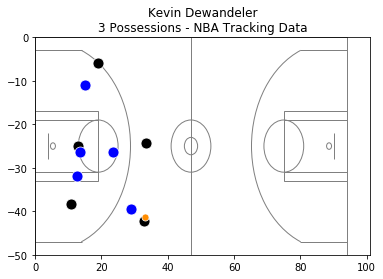

In [14]:
## Example plot

t1_x_vals = new_test.iloc[0][['t1_p1_x','t1_p2_x','t1_p3_x','t1_p4_x','t1_p5_x']].values.tolist()
t1_y_vals = new_test.iloc[0][['t1_p1_y','t1_p2_y','t1_p3_y','t1_p4_y','t1_p5_y']].values.tolist()
t2_x_vals = new_test.iloc[0][['t2_p1_x','t2_p2_x','t2_p3_x','t2_p4_x','t2_p5_x']].values.tolist()
t2_y_vals = new_test.iloc[0][['t2_p1_y','t2_p2_y','t2_p3_y','t2_p4_y','t2_p5_y']].values.tolist()
ball_x = [new_test.iloc[0]['Ball_X']]
ball_y = [new_test.iloc[0]['Ball_Y']]

sns.scatterplot(t1_x_vals, t1_y_vals,color = 'black', s = 120)
sns.scatterplot(t2_x_vals, t2_y_vals,color = 'blue', s = 120)
sns.scatterplot(ball_x, ball_y, color = 'darkorange', s = 50)
draw_court()

fig1 = plt.gcf()
plt.xlim(0, 101)
plt.ylim(-50,0)
plt.title("Kevin Dewandeler\n3 Possessions - NBA Tracking Data")
plt.show()

In [15]:
## Putting images into a movie

import cv2
import numpy as np
 
img=[]
for i in range(len(image_list)):
    img.append(cv2.imread('/Users/kevindewandeler/Downloads/Image File/test_img_' + str(i) + '.jpg'))

height,width,layers=img[1].shape

## Saved as 'video_newest.mp4' upon output
video=cv2.VideoWriter('video_newest.mp4',-1,22,(width,height))

for j in range(0,1150):
    video.write(img[j])

cv2.destroyAllWindows()
video.release()